# Coding an LLM architecture

In [2]:
GPT_CONFIG_124M = {
  "vocab_size": 50257, # vocab size 
  "embed_dim": 768, # embedding dimension
  "context_length": 1024, # context length
  "drop_rate": 0.1, # dropout rate
  "n_layers": 12, # number of layers (how many transformer blocks we want to stack)
  "n_heads": 12, # number of attention heads4
  "qkv_bias": False # whether to use bias in the QKV layer
}


In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embed_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embed_dim"])
    self.dropout = nn.Dropout(cfg["drop_rate"])

    # Placeholder for the transformer blocks
    self.trf_blocks = nn.Sequential(
      *[DummyTransformerBlock(cfg["embed_dim"]) for _ in range(cfg["n_layers"])]
    )

    # Placeholder for layer norm
    self.final_norm = DummyLayerNorm(cfg["embed_dim"])
    self.out_head = nn.Linear(
      cfg["embed_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.dropout(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    # just a placeholder for the transformer block
    pass

  def forward(self, x):
    # does not do anything, just a placeholder
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()
    # just a placeholder for the layer norm
    pass

  def forward(self, x):
    # does not do anything, just a placeholder
    return x




In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Hello, how are you?"
txt2 = "I'm fine, thanks!"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)






tensor([[15496,    11,   703,   389,   345,    30],
        [   40,  1101,  3734,    11,  5176,     0]])


In [5]:
batch.shape

torch.Size([2, 6])

In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print("Logits:", logits)

Output shape: torch.Size([2, 6, 50257])
Logits: tensor([[[ 0.1863, -0.5487,  0.4876,  ..., -0.0398,  0.4186, -0.1547],
         [ 0.3518,  0.9714, -0.8348,  ...,  0.8093, -0.2861,  1.2434],
         [-0.0855,  1.9188, -0.0133,  ...,  1.1934,  0.8300, -0.0104],
         [ 0.0090, -0.6126,  0.6045,  ...,  1.6387,  0.7650, -0.7919],
         [ 0.4482,  0.5461,  0.2741,  ..., -0.2531, -1.1501, -1.3639],
         [ 0.0895,  0.2768, -0.4310,  ...,  1.2816,  0.5306,  0.3432]],

        [[ 0.6431, -0.7578,  0.0666,  ...,  0.3780,  0.9720, -0.1389],
         [ 1.3281,  0.1608, -0.6110,  ...,  0.3058, -0.3893,  1.5481],
         [ 0.0215,  1.0764,  1.0452,  ...,  0.2514, -0.0103, -1.4550],
         [ 1.0461,  1.4003, -0.0582,  ...,  2.1026, -0.2353, -0.6815],
         [-1.1840,  0.1493,  1.0145,  ...,  0.5153, -0.6887, -0.5509],
         [ 0.5185,  0.0710,  0.7378,  ...,  1.0410,  0.0434,  0.0287]]],
       grad_fn=<UnsafeViewBackward0>)


## Normalizing activations with layer normalization

In [7]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)

batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [8]:
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.7286, 0.6817, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1721, 0.0000, 0.0000, 0.0000, 0.8324, 0.1910]],
       grad_fn=<ReluBackward0>)

In [9]:
# mean = out.mean(dim=1) # dim=1 means the mean of each row
# or better use -1 as dim, which is the last dimension
mean = out.mean(dim=-1, keepdim=True)
mean

tensor([[0.2350],
        [0.1992]], grad_fn=<MeanBackward1>)

In [10]:
var = out.var(dim=-1, keepdim=True)
var

tensor([[0.1328],
        [0.1041]], grad_fn=<VarBackward0>)

In [11]:
torch.set_printoptions(sci_mode=False)

normed = ((out - mean) / torch.sqrt(var))
normed.var(dim=-1, keepdim=True)

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

In [12]:
normed.var(dim=-1, keepdim=True)

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

In [13]:
from torch import norm_except_dim


class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 # 0.00001
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False) 
    # unbiased=False means we use the population variance to mimic the gpt2 implementation
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift




    


In [14]:
ln = LayerNorm(6)
outputs_normed = ln(out)
outputs_normed




tensor([[ 1.4835,  1.3425, -0.7065, -0.7065, -0.7065, -0.7065],
        [-0.0920, -0.6763, -0.6763, -0.6763,  2.1489, -0.0280]],
       grad_fn=<AddBackward0>)

In [15]:
outputs_normed.mean(dim=-1, keepdim=True)

tensor([[ 0.0000],
        [-0.0000]], grad_fn=<MeanBackward1>)

In [16]:
outputs_normed.var(dim=-1, keepdim=True)

tensor([[1.1999],
        [1.1999]], grad_fn=<VarBackward0>)

## Implementing a feed forward network with GELU activations

In [17]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    # we are using the approximation of the GELU activation function to mimic the gpt2 implementation
    return 0.5 * x * (1 + torch.tanh(
      torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
      (x + 0.044715 * torch.pow(x, 3.0))
    ))


In [18]:
gelu = GELU()
gelu(out)






tensor([[0.5587, 0.5128, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0978, 0.0000, 0.0000, 0.0000, 0.6636, 0.1100]],
       grad_fn=<MulBackward0>)

### Visualize the GELU function

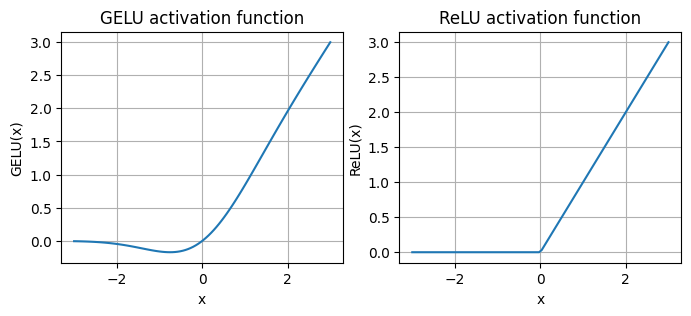

In [19]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# sample data
x = torch.linspace(-3, 3, 100)
y_gelu = gelu(x)
y_relu = relu(x)

# plot the results
plt.figure(figsize=(8, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)




plt.show()



In [20]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(cfg["embed_dim"], 4 * cfg["embed_dim"]), # 4 is what gpt2 uses
      GELU(),
      nn.Linear(4 * cfg["embed_dim"], cfg["embed_dim"])
    )

  def forward(self, x):
    return self.layers(x)




In [21]:
ffn = FeedForward(GPT_CONFIG_124M)

In [22]:
x = torch.randn(2, 3, 768)
ffn(x).shape








torch.Size([2, 3, 768])

In [23]:
ffn.layers[0].weight

Parameter containing:
tensor([[ 0.0148, -0.0353, -0.0022,  ...,  0.0333, -0.0356,  0.0199],
        [-0.0170, -0.0258,  0.0280,  ...,  0.0240,  0.0314,  0.0344],
        [ 0.0082,  0.0230,  0.0001,  ..., -0.0335,  0.0171, -0.0037],
        ...,
        [ 0.0281,  0.0268, -0.0041,  ..., -0.0031, -0.0273, -0.0046],
        [-0.0025, -0.0127, -0.0169,  ..., -0.0045, -0.0046, -0.0345],
        [ 0.0264, -0.0037,  0.0053,  ..., -0.0051, -0.0041,  0.0070]],
       requires_grad=True)

## Adding shortcut connections

In [24]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
      nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
    ])
    
  def forward(self, x):
    for layer in self.layers:
     # computer the output of the current layer
     layer_output = layer(x)
     # check if shortcut can be applied
     if self.use_shortcut and x.shape == layer_output.shape:
      x = x + layer_output
     else:
      x = layer_output
    return x

def print_gradients(model, x):
  # forward pass
  output = model(x)
  target = torch.tensor([[0.]]) # placeholder target for the loss function as we are not training

  # compute loss
  loss = nn.MSELoss() # just for simplicity, we use a simple loss function
  loss = loss(output, target)

  # backward pass to calculate gradients
  loss.backward()

  # print the gradients
  for name, param in model.named_parameters():
    if 'weight' in name:
      # print the mean absolute gradients of the weights
      print(f"{name} has a gradient mean of {param.grad.abs().mean().item()}")









    
    

In [25]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
use_shortcut = False

torch.manual_seed(123)

model = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut)

print_gradients(model, sample_input)


layers.0.0.weight has a gradient mean of 0.00020173587836325169
layers.1.0.weight has a gradient mean of 0.0001201116101583466
layers.2.0.weight has a gradient mean of 0.0007152041071094573
layers.3.0.weight has a gradient mean of 0.0013988735154271126
layers.4.0.weight has a gradient mean of 0.005049645435065031


In [26]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
use_shortcut = True

torch.manual_seed(123)

model = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut)

print_gradients(model, sample_input)


layers.0.0.weight has a gradient mean of 0.22169791162014008
layers.1.0.weight has a gradient mean of 0.20694106817245483
layers.2.0.weight has a gradient mean of 0.32896995544433594
layers.3.0.weight has a gradient mean of 0.2665732204914093
layers.4.0.weight has a gradient mean of 1.3258540630340576


## Connecting attention and linear layers in a transformer block

In [ ]:
# Import code from chapter-3.ipynb and chapter-2.ipynb that we need here
import sys
# Add the directory containing this notebook to Python path
notebook_dir = '/Users/wolf/ai/LLMs-from-scratch/build_an_llm_from_scratch'
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)
    
from previous_chapters_two_three import MultiHeadAttention

In [33]:


class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
      d_in = cfg["embed_dim"],
      d_out = cfg["embed_dim"],
      context_length = cfg["context_length"],
      num_heads = cfg["n_heads"],
      dropout = cfg["drop_rate"],
      qkv_bias = cfg["qkv_bias"]
    )

    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["embed_dim"])
    self.norm2 = LayerNorm(cfg["embed_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x # keep the x from the previous layer for the shortcut connection
    x = self.norm2(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = x + shortcut # add the shortcut connection

    return x




In [38]:
torch.manual_seed(123)

model = TransformerBlock(GPT_CONFIG_124M)

x = torch.rand(2, 4, 768)

output = model(x)
output


tensor([[[ 0.1416,  0.2467,  0.2317,  ...,  0.1780,  0.1966,  1.3443],
         [ 0.0929,  0.3889,  0.6629,  ...,  1.1015,  0.3640,  0.4361],
         [ 0.2067,  0.5458,  0.1572,  ..., -0.2758,  0.6164,  0.4802],
         [ 0.4659,  0.4988,  0.8070,  ..., -0.1181,  0.2424,  1.3027]],

        [[ 0.9658,  1.2531,  1.2318,  ...,  0.5799,  0.0377,  0.4316],
         [ 0.5739, -0.0013,  0.6739,  ...,  0.3818,  0.5303,  0.2684],
         [ 0.9065,  0.4001,  0.2467,  ...,  0.1645,  0.8935,  1.2748],
         [ 0.9911,  0.7147,  0.3522,  ...,  0.6840,  0.2418,  0.5326]]],
       grad_fn=<AddBackward0>)

In [40]:
x.shape


torch.Size([2, 4, 768])

In [39]:
output.shape

torch.Size([2, 4, 768])

## Coding the GPT Model

In [46]:
# copied from above
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [47]:
batch.shape

torch.Size([2, 4])

In [50]:
# based on the DummyGPTModel class from above

class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embed_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embed_dim"])
    self.dropout = nn.Dropout(cfg["drop_rate"])

    # Placeholder for the transformer blocks
    self.trf_blocks = nn.Sequential(
      *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    # Placeholder for layer norm
    self.final_norm = LayerNorm(cfg["embed_dim"])
    self.out_head = nn.Linear(
      cfg["embed_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.dropout(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [51]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)


output = model(batch)
output 

tensor([[[ 0.7053,  0.3617,  0.0581,  ...,  0.5794,  0.4369, -0.5395],
         [ 0.3149, -0.4990, -0.7606,  ...,  0.0588,  0.2850, -0.2483],
         [ 1.0219,  0.0603,  0.0629,  ..., -0.0370, -0.3881, -0.1416],
         [-0.5710,  0.1734, -0.4368,  ...,  0.8466,  0.2312, -0.2404]],

        [[-0.3798,  0.2834, -0.1104,  ...,  0.1926,  0.3591, -0.8746],
         [ 0.1633,  0.2323,  0.2081,  ...,  0.9451, -0.2375,  0.3755],
         [ 1.0812,  0.8785, -0.1139,  ...,  0.8412,  0.3455, -0.1142],
         [ 0.1560,  0.1270,  0.4120,  ...,  1.2442, -0.5060,  0.2523]]],
       grad_fn=<UnsafeViewBackward0>)

In [52]:
output.shape

torch.Size([2, 4, 50257])

In [53]:
batch.numel()

8

In [54]:
total_params = sum(p.numel() for p in model.parameters())
total_params


163009536

In [55]:
print(f"Total parameters: {total_params:,}")

Total parameters: 163,009,536


We have more than 124 million parameters because we do not do weight sharing for input and output embedding. 

In the original GPT-2, the input embedding matrix (tok_emb) and the output projection matrix (out_head) share the same weights. This reduces parameters.

In [58]:
print(f"Total parameters of the original GPT-2 model: {total_params - model.out_head.weight.numel():,}")


Total parameters of the original GPT-2 model: 124,412,160


### Current implementation (no weight sharing)
Looking at the GPTModel class:

- `self.tok_emb = nn.Embedding(vocab_size, embed_dim)` — creates a matrix of size (50257, 768)
- `self.out_head = nn.Linear(embed_dim, vocab_size, bias=False)` — creates a matrix of size (768, 50257)

These are separate, so you have:

- Embedding parameters: 50257 × 768 = 38,597,376
- Output head parameters: 768 × 50257 = 38,597,376
- Total for these two: 77,194,752 parameters

### Original GPT-2 (with weight sharing)
If the weights are shared (typically by tying `out_head.weight = tok_emb.weight.T`), you only store one set:
- Shared parameters: 50257 × 768 = 38,597,376 parameters
This saves about 38.6 million parameters.

## Generating Text

In [67]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:] # truncating to the size the model supports (if it was longer)

    with torch.no_grad(): # we are not training, so we do not need to compute gradients
      logits = model(idx_cond)
    logits = logits[:, -1, :] # only the last row of the logits (the new token)

    probas = torch.softmax(logits, dim=-1) # computing the probabilities
    idx_next = torch.argmax(probas, dim=-1, keepdim=True) # argmax looks up the index position (finding the index position with the highest probability)

    idx = torch.cat((idx, idx_next), dim=1) # concatenating the new token to the context

  return idx

idx (index) corresponds to token id 

In [65]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

# model expects a batch dimension even if we only have one example
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)



encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [66]:
encoded_tensor

tensor([[15496,    11,   314,   716]])

In [69]:
out = generate_text_simple(
  model=model, 
  idx= encoded_tensor, 
  max_new_tokens=6, 
  context_size=GPT_CONFIG_124M["context_length"] 
)
out





tensor([[15496,    11,   314,   716, 45985,  7283, 46275, 31377, 10595,  8262]])

In [71]:
tokenizer.decode(out[0].tolist()) # we have to convert the tensor to a list first because the tokenizer expects a list of tokens

'Hello, I am pinnacle IT snowball maple wider chart'